In [2]:
import os
import cv2
import rasterio
from rasterio.plot import reshape_as_image
import rasterio.mask
from rasterio.features import rasterize
import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from geopandas import GeoSeries
from shapely.geometry import Polygon
from rasterio.windows import Window
from rasterio.plot import reshape_as_image


%matplotlib inline

2 most usefull types of satellite imagery:

* Sentinel-2
    
    Max - 10 meters per pixel
    
    Download tiles: https://scihub.copernicus.eu/dhus/#/home




* Landsat-8

    Max - 30 meters per pixel
    
    Download tiles: https://earthexplorer.usgs.gov/

QGIS. Check the data

Reading Raster with rasterio

In [5]:
PROJECT_DIR = '/home/mikolaj/github/quantum_geo/warsaw_ws/warsaw_ws_data'

RASTER_PATH = os.path.join(PROJECT_DIR, 'T34JEP_20170101T082332/T34JEP_20170101T082332_TCI.jp2')
TRAIN_POLYGONS_PATH = os.path.join(PROJECT_DIR, 'train-20220726T194123Z-001/train/train.shp')
TEST_POLYGONS_PATH = os.path.join(PROJECT_DIR, 'train-20220726T194123Z-001/test/test.shp')
TRAIN_POLYGONS_CONVERTED = os.path.join(PROJECT_DIR, 'train-20220726T194123Z-001/train/train_test.geojson')

In [6]:
#read TCI RASTER_PATH 
# get raster and metadata

with rasterio.open(RASTER_PATH) as src:
    raster = src.read()
    meta = src.meta

In [7]:
#check raster metadata
meta

{'driver': 'JP2OpenJPEG',
 'dtype': 'uint8',
 'nodata': None,
 'width': 10980,
 'height': 10980,
 'count': 3,
 'crs': CRS.from_epsg(32734),
 'transform': Affine(10.0, 0.0, 499980.0,
        0.0, -10.0, 6900040.0)}

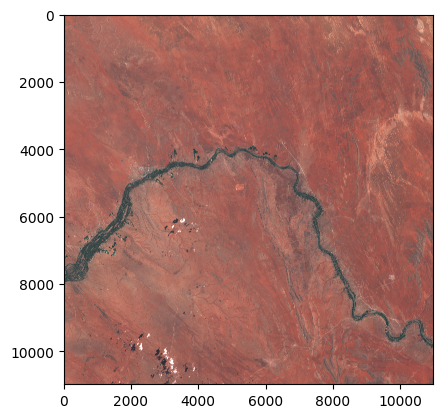

In [11]:
#plot image
plt.imshow(reshape_as_image(raster))

In [15]:
test = gpd.read_file(TEST_POLYGONS_PATH)
train = gpd.read_file(TRAIN_POLYGONS_PATH)\

test

,Field_Id,Area,Subregion,geometry
0,5,1.322590,3,"POLYGON ((2468454.793 -3351779.658, 2468482.57..."
1,6,0.955864,3,"POLYGON ((2468670.690 -3351827.266, 2468685.51..."
2,10,11.509800,3,"POLYGON ((2468365.449 -3351541.136, 2468357.74..."
3,18,2.697520,3,"POLYGON ((2437080.102 -3334938.835, 2437183.73..."
4,23,4.238030,3,"POLYGON ((2437320.481 -3334595.737, 2437352.06..."
...,...,...,...,...
1069,3595,4.026750,6,"POLYGON ((2388276.171 -3279964.264, 2388428.17..."
1070,3601,3.291510,7,"POLYGON ((2384928.766 -3283470.511, 2384742.23..."
1071,3604,0.202729,3,"POLYGON ((2468001.492 -3351672.921, 2468007.44..."
1072,3605,0.252428,3,"POLYGON ((2467920.067 -3351463.579, 2467970.33..."


In [19]:
# concat and reset the index
data = pd.concat([test, train]).reset_index(drop=True)
data

,Field_Id,Area,Subregion,geometry,Crop_Id_Ne
0,5,1.322590,3,"POLYGON ((2468454.793 -3351779.658, 2468482.57...",NaN
1,6,0.955864,3,"POLYGON ((2468670.690 -3351827.266, 2468685.51...",NaN
2,10,11.509800,3,"POLYGON ((2468365.449 -3351541.136, 2468357.74...",NaN
3,18,2.697520,3,"POLYGON ((2437080.102 -3334938.835, 2437183.73...",NaN
4,23,4.238030,3,"POLYGON ((2437320.481 -3334595.737, 2437352.06...",NaN
...,...,...,...,...,...
3566,3598,4.660920,7,"POLYGON ((2384342.745 -3283256.510, 2384353.85...",6
3567,3599,4.829750,7,"POLYGON ((2383912.135 -3283350.967, 2383935.94...",6
3568,3600,7.543830,7,"POLYGON ((2384231.275 -3283492.534, 2384409.86...",6
3569,3602,5.144850,6,"POLYGON ((2387552.792 -3280598.872, 2387782.98...",6


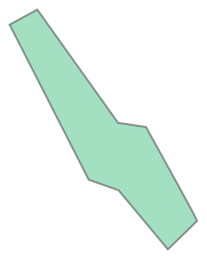

In [25]:
#visualize polygon
data.geometry[0]

<Axes: >

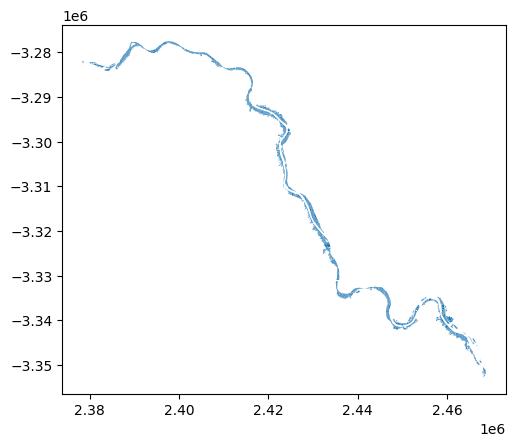

In [26]:
data.plot()

In [35]:
# check polygon coordinates
print(data.geometry[0])
data["geometry"][0].exterior.coords.xy

POLYGON ((2468454.792855258 -3351779.658448273, 2468482.5741608106 -3351764.5771728284, 2468563.536822737 -3351878.083614247, 2468591.623687613 -3351882.3906140677, 2468623.597359525 -3351940.260802432, 2468638.6786396895 -3351968.0420992756, 2468642.911981496 -3351976.508780218, 2468613.5431727506 -3352005.0838284157, 2468564.0659904573 -3351945.817061804, 2468534.1680139983 -3351935.233710623, 2468454.792855258 -3351779.658448273))


(array('d', [2468454.792855258, 2468482.5741608106, 2468563.536822737, 2468591.623687613, 2468623.597359525, 2468638.6786396895, 2468642.911981496, 2468613.5431727506, 2468564.0659904573, 2468534.1680139983, 2468454.792855258]),
 array('d', [-3351779.658448273, -3351764.5771728284, -3351878.083614247, -3351882.3906140677, -3351940.260802432, -3351968.0420992756, -3351976.508780218, -3352005.0838284157, -3351945.817061804, -3351935.233710623, -3351779.658448273]))

In [33]:
# bounds of raster
src.bounds

BoundingBox(left=499980.0, bottom=6790240.0, right=609780.0, top=6900040.0)

In [39]:
# try to crop raster by polygon bounds
src = rasterio.open(RASTER_PATH)

failed = []
for i, row in data.iterrows():
    try:
        masked_image, mask_transform = rasterio.mask.mask(src, [row["geometry"]], crop=True, nodata=0)
    except:
        print(f"Failed at: {i}")
        failed.append(i)


Failed at: 0
Failed at: 1
Failed at: 2
Failed at: 3
Failed at: 4
Failed at: 5
Failed at: 6
Failed at: 7
Failed at: 8
Failed at: 9
Failed at: 10
Failed at: 11
Failed at: 12
Failed at: 13
Failed at: 14
Failed at: 15
Failed at: 16
Failed at: 17
Failed at: 18
Failed at: 19
Failed at: 20
Failed at: 21
Failed at: 22
Failed at: 23
Failed at: 24
Failed at: 25
Failed at: 26
Failed at: 27
Failed at: 28
Failed at: 29
Failed at: 30
Failed at: 31
Failed at: 32
Failed at: 33
Failed at: 34
Failed at: 35
Failed at: 36
Failed at: 37
Failed at: 38
Failed at: 39
Failed at: 40
Failed at: 41
Failed at: 42
Failed at: 43
Failed at: 44
Failed at: 45
Failed at: 46
Failed at: 47
Failed at: 48
Failed at: 49
Failed at: 50
Failed at: 51
Failed at: 52
Failed at: 53
Failed at: 54
Failed at: 55
Failed at: 56
Failed at: 57
Failed at: 58
Failed at: 59
Failed at: 60
Failed at: 61
Failed at: 62
Failed at: 63
Failed at: 64
Failed at: 65
Failed at: 66
Failed at: 67
Failed at: 68
Failed at: 69
Failed at: 70
Failed at: 71
Fa

In [41]:
# checking geometry
data["geometry"][3000].exterior.coords.xy

(array('d', [2430119.106687784, 2430139.4796452, 2430167.7901184894, 2430175.992218226, 2430191.867249977, 2430206.154778555, 2430155.8838446736, 2430153.238006048, 2430128.3671229705, 2430114.6087621227, 2430097.146227192, 2430089.2087113224, 2430119.106687784]),
 array('d', [-3319157.11135073, -3319128.007125858, -3319011.9606437534, -3319019.3689919077, -3319050.325303819, -3319076.7836900726, -3319263.050729286, -3319267.5486549474, -3319274.9570031017, -3319275.2215869613, -3319270.7236613, -3319267.284071084, -3319157.11135073]))

1. Go to http://projfinder.com/
2. We know the data came from South Africa let’s zoom into it.
3. Use it with any coordinates from the GeoDataframe and check the output. We are looking for a place in South Africa, that has a river — we can see it in our image. Looking through the results we will see one that fits: EPSG:3395 Name: WGS 84 / World Mercator.

In [61]:
# assigning crs
data_crs = data.to_crs(3395)

In [47]:
data.crs

<Derived Projected CRS: PROJCS["Mercator_2SP",GEOGCS["WGS 84",DATUM["D_unk ...>
Name: Mercator_2SP
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Mercator (variant B)
Datum: D_unknown
- Ellipsoid: WGS84
- Prime Meridian: Greenwich

In [60]:
# check updated crs
data_crs.crs

<Derived Projected CRS: EPSG:3395>
Name: WGS 84 / World Mercator
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World between 80°S and 84°N.
- bounds: (-180.0, -80.0, 180.0, 84.0)
Coordinate Operation:
- name: World Mercator
- method: Mercator (variant A)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [62]:
# let's remove rows without geometry
data_crs = data_crs[data_crs.geometry.notnull()]
# transform polygons to raster crs
data_crs.to_crs(src.crs, inplace=True)

data_crs.crs

<Derived Projected CRS: EPSG:32734>
Name: WGS 84 / UTM zone 34S
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 34S
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [63]:
# check again bounds of raster
src = rasterio.open(RASTER_PATH)

failed = []
for i, row in data_crs.iterrows():
    try:
        masked_image, mask_transform = rasterio.mask.mask(src, [row["geometry"]], crop=True, nodata=0)
    except:
        print(f"Failed at: {i}")
        failed.append(i)

print(f"failed {len(failed)}")

Failed at: 0
Failed at: 1
Failed at: 2
Failed at: 28
Failed at: 29
Failed at: 30
Failed at: 31
Failed at: 32
Failed at: 33
Failed at: 34
Failed at: 35
Failed at: 36
Failed at: 37
Failed at: 38
Failed at: 39
Failed at: 40
Failed at: 73
Failed at: 74
Failed at: 75
Failed at: 76
Failed at: 77
Failed at: 78
Failed at: 79
Failed at: 80
Failed at: 81
Failed at: 82
Failed at: 83
Failed at: 84
Failed at: 85
Failed at: 86
Failed at: 87
Failed at: 88
Failed at: 89
Failed at: 90
Failed at: 91
Failed at: 92
Failed at: 93
Failed at: 94
Failed at: 95
Failed at: 659
Failed at: 660
Failed at: 661
Failed at: 662
Failed at: 730
Failed at: 731
Failed at: 732
Failed at: 733
Failed at: 734
Failed at: 735
Failed at: 743
Failed at: 744
Failed at: 806
Failed at: 807
Failed at: 808
Failed at: 875
Failed at: 876
Failed at: 877
Failed at: 878
Failed at: 879
Failed at: 880
Failed at: 962
Failed at: 1011
Failed at: 1012
Failed at: 1024
Failed at: 1025
Failed at: 1060
Failed at: 1068
Failed at: 1071
Failed at: 1072

In [57]:
# save converted dataframe
data_crs.to_file(TRAIN_POLYGONS_CONVERTED, driver="GeoJSON")